# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

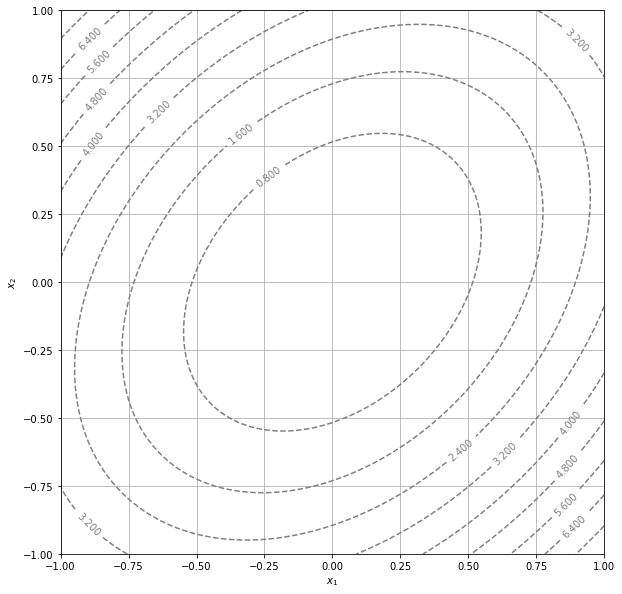

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

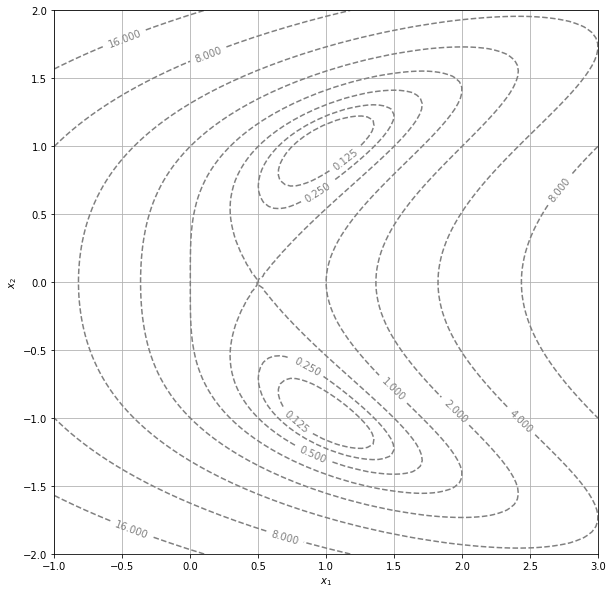

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

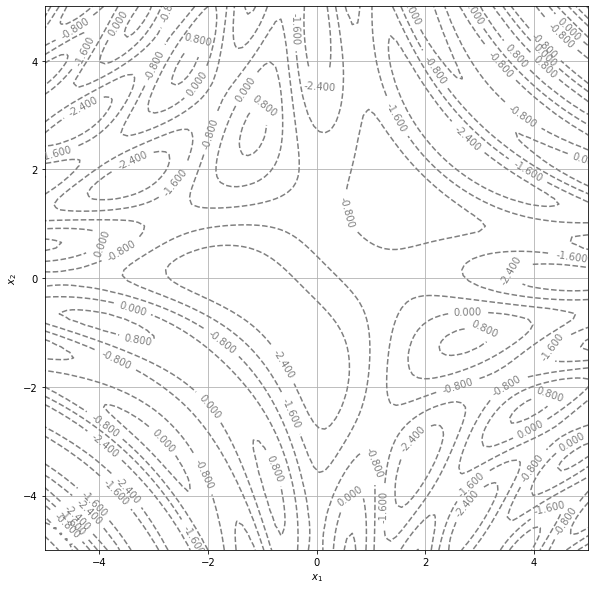

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

##### Réponse 1
Nous allons montrer que l'ensemble de niveau de c est un compact, 

f est continue, donc $f^{-1}[{c}]$ est l'image réciproque d'un fermé par une fonction continue. C'est donc un ensemble fermé. 
Montrons à présent le caractère borné: 
par l'absurde, si $f^{-1}[{c}]$ était non borné, on pourrait extraire une suite de couples $(x_n,y_n)$ tel que $\|(x_n,y_n)\| \to +\infty$ et $f(x_n,y_n)=c$. Cela contredirait alors l'hypothèse, f tend vers l'infini quand $\|(x_1,x_2)\| \to +\infty$.

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

##### Réponse 2

On reconnaît l'expression du déterminant $\begin{vmatrix} x_1-x_{10} & \frac{\partial_1 f(x_0)}{\|\nabla(f(x_0))\|} \\ x_2-x_{20} & \frac{\partial_2 f(x_0)}{\|\nabla(f(x_0))\|} \end{vmatrix}$
dans la définition de $p$. 
Le vecteur $\begin{pmatrix} \frac{\partial_1 f(x_0)}{\|\nabla(f(x_0))\|}  \\ \frac{\partial_2 f(x_0)}{\|\nabla(f(x_0))\|} \end{pmatrix}$ représente le gradient de f en $x_0$ ramené à un vecteur unitaire. Le vecteur $\begin{pmatrix} x_1-x_{10} \\ x_2-x_{20} \end{pmatrix}$ représente le vecteur entre notre point $x=\begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$ et le point fixé arbitrairement $x_0=\begin{pmatrix} x_{10} \\ x_{20} \end{pmatrix}$. Une représentation géométrique de notre déterminant est donc l'aire formée par le parallèlépipède entre ces deux vecteurs.



#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

##### Réponse 3

Utilisons le théorème des fonctions implicites appliqué à la fonction $g$ de $\mathbb{R}^2\times\mathbb{R}$ vers $\mathbb{R}$ définie par :
$g((x_1,x_2),t)= \begin{pmatrix} f(x_1,x_2)-c \\ p(x_1,x_2)-t \end{pmatrix}$.

$f$ est continûment différentiable sur l'ouvert $\mathbb{R}^2$ et comme c'est une fonction affine en ses coordonnées, p également. Par composée, $g$ est continûment différentiable sur $\mathbb{R}^2$.


De plus, montrons que $\partial_xg(x,t)$ est inversible en $x=(x_{10},x_{20})$ :
$\partial_xg(x_{10},x_{20})=\begin{pmatrix} \frac{\partial_f}{\partial_{x_1}}(x_0) & \frac{\partial_f}{\partial_{x_2}}(x_0) \\ \frac{\partial_p}{\partial_{x_1}}(x_0) & \frac{\partial_p}{\partial_{x_2}}(x_0) \end{pmatrix}= \begin{pmatrix} \partial_1 f(x_0) & \partial_2 f(x_0) \\ \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} \end{pmatrix}$

Or le déterminant de cette matrice vaut :
$\begin{vmatrix} \partial_1 f(x_0) & \partial_2 f(x_0) \\ \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} \end{vmatrix} = -(\partial_1 f(x_0)^2 +\partial_2 f(x_0)^2) \times \frac{1}{\|\nabla f(x_0)\|}$ et est nul si et seulement si $\partial_1 f(x_0)=\partial_2 f(x_0)=0$ cela imposerait, $\nabla f(x_0)=0$ ce qui est faux par hypothèse. Le déterminant étant non nul, notre matrice est donc inversible.

Donc $\partial_xg(x,t)$ est inversible.

Et, $g(x_0,0)=0$


D'après le théorème des fonctions implicites, il existe un voisinage ouvert $U$ de $x_0$ et $V$ de $0$ (on peut donc écrire $V=\left]-\varepsilon, \varepsilon \right[$ où $\varepsilon > 0$ quitte à réduire $V$) et un unique fonction implicite $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ continûment différentiable, telle que :
$\forall x \in U,\forall t \in \left]-\varepsilon,\varepsilon \right[, g(x,t)=0 \Leftrightarrow x=\gamma(t)$

Donc $f(x_1,x_2)=c$ et $p(x_1,x_2)=t$ équivaut à avoir $(x_1,x_2)=\gamma(t)$. D'où, si $f(x_1,x_2)=c$, en notant $t=p(x_1,x_2)$, on obtient ; $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

##### Réponse 4


En utilisant le théorème des fonctions implicites; on exprime :
    $\mathrm{d}\gamma(t) = -(\partial_xg(x,t))^{-1}\circ\partial_tg(x,t)$
Donc $\gamma'(t) = -(\partial_xg(x,t))^{-1}\circ\partial_tg(\gamma(t),t)$
Détaillons $\partial_xg(x,t) =  \begin{pmatrix} \partial_1 f(x) & \partial_2 f(x) \\ \frac{\partial_2 f(x)}{\|\nabla f(x)\|} & -\frac{\partial_1 f(x)}{\|\nabla f(x)\|} \end{pmatrix}$
$\partial_xg(x,t))^{-1}= \frac{1}{-(\partial_1 f(x)^2 +\partial_2 f(x)^2) \times \frac{1}{\|\nabla f(x)\|}} \times \begin{pmatrix} -\frac{\partial_1 f(x)}{\|\nabla f(x)\|} & -\partial_2 f(x) \\ -\frac{\partial_2 f(x)}{\|\nabla f(x)\|} & \partial_1 f(x) \end{pmatrix}$
et $\partial_tg(\gamma(t),t) = \begin{pmatrix} 0 \\ -1 \end{pmatrix} $

$\gamma'(t) = \frac{1}{-(\partial_1 f(x)^2 +\partial_2 f(x)^2)\times \frac{1}{\|\nabla f(x)\|}} \times \begin{pmatrix} \partial_2 f(x) \\ -\partial_1 f(x) \end{pmatrix}$ avec $x=\gamma(t)$

L'orthogonalité à $\nabla f(\gamma(t))$ est alors immédiate: 
$\nabla f(\gamma(t)) = \begin{pmatrix} \partial_1 f(x) \\ \partial_2 f(x) \end{pmatrix} $ et $(\nabla f(\gamma(t)) | \gamma'(t))= \frac{1}{-(\partial_1 f(x)^2 +\partial_2 f(x)^2)\times \frac{1}{\|\nabla f(x)\|}} \times (\partial_1 f(x) \times \partial_2 f(x) - \partial_1 f(x) \times \partial_2 f(x)) = 0$

On constate bien que $\gamma'(t)$ est non nul car $x$ est au voisinage de $x_0$ où l'on a supposé par hyothèse que le gradient ne s'annulait pas

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [14]:
N = 100
eps = 10e-6

On veut tracer des lignes de niveaux. Une grande précision n'est pas nécessairement requise. Surtout que l'on souhaite réinterpoler avant de tracer la ligne. La précision $10^{-2}$ semble donc suffisante. De plus, la méthode de Newton convergeant vite, on trouvera une solution en moins de 100 itérations.

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    jac= J(F)

    for i in range(N):
        V0=np.dot(np.linalg.inv(jac(x0,y0)),F(x0,y0))
        x= x0 - V0[0]
        y= y0 - V0[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

(0.4472135954999579, 0.4472135954999579)


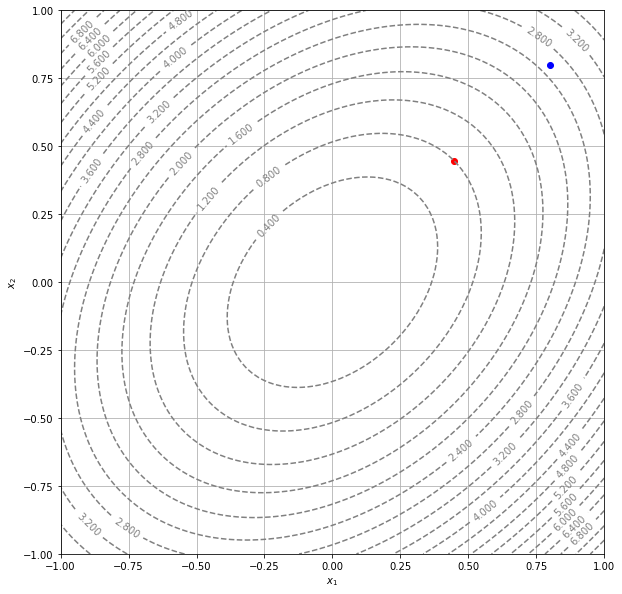

In [16]:
#On part du point bleu en (0.8,0.8) pour arriver
#sur le courbe de niveau 0.8 avec x = y

def F(x,y,ct=0.8):
    return np.array([f1(x,y)-ct,x-y])
point=Newton(F,0.8,0.8)
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=20, # 20 levels, automatically selected
)
plt.scatter(0.8,0.8,color='b')
plt.scatter(point[0],point[1],color='r')
print(point)

(-0.22360679775166067, 0.22360679775166067)


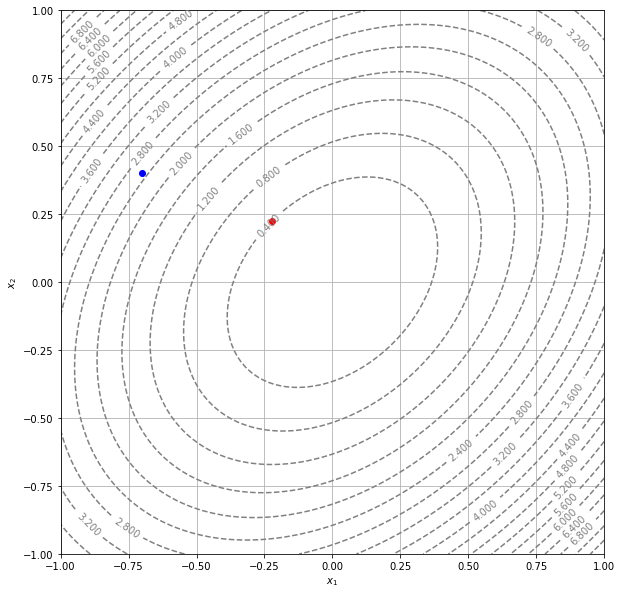

In [17]:
#On part du point bleu en (-0.7,0.4) pour arriver
#sur le courbe de niveau 0.4 avec x = -y

def F(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.array([f1(x1,x2) - 0.4 , x1+x2])

point=Newton(F,-0.7,0.4)
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=20, # 20 levels, automatically selected
)
plt.scatter(-0.7,0.4,color='b')
plt.scatter(point[0],point[1],color='r')
print(point)

(-0.6324555320371593, -0.6324555320371593)


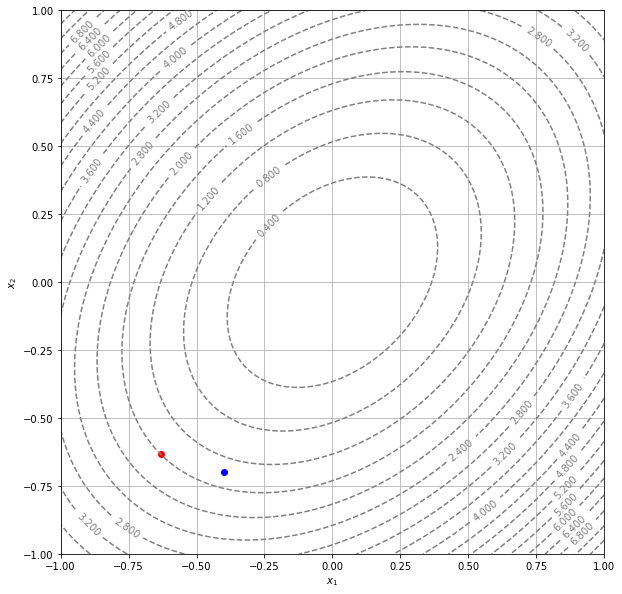

In [18]:
#On part du point bleu en (-0.4,-0.7) pour arriver
#sur le courbe de niveau 1.6 avec x = y

def F(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.array([f1(x1,x2) - 1.6 , x1-x2])

point=Newton(F,-0.4,-0.7)
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=20, # 20 levels, automatically selected
)
plt.scatter(-0.4,-0.7,color='b')
plt.scatter(point[0],point[1],color='r')
print(point)

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

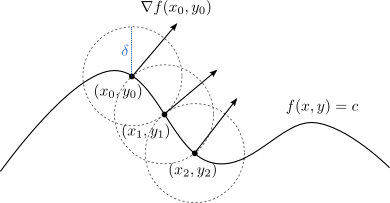

Idée : on part du point $(x_0,y_0)+\delta\times\vec{n}$ où $\vec{n}$ est un vecteur orthogonal à $\nabla f(x_0, y_0)$ de norme 1 et allant vers la droite. Pour la seconde contrainte, on demande au nouveau point d'être sur le cercle de centre $(x_0,y_0)$ et de rayon $\delta$.

In [19]:
from math import *
def vect_normal(vg, x0, y0,delta):
    xg,yg=vg[0],vg[1]
    v=np.array([yg,-xg])
    v= (v/sqrt(v[0]**2+v[1]**2))*delta

    return x0+v[0],y0+v[1]#retourne les coordonnées du point au bout du vecteur de longueur delta, normal à vg et partant de (x0,y0)
    
    
def level_curve(f, x0, y0,N=1000, delta=0.1, eps=eps):
    Lx=[x0]
    Ly=[y0]
    gr=grad(f)
    x01,y01=vect_normal(gr(x0,y0),x0,y0,delta)
    ct=f(x0,y0)
    for i in range(N-1):#pour avoir un tableau de taille N
        def F(x,y):
            return np.array([f(x,y)-ct,((x-x0)**2+(y-y0)**2)**(1/2)-delta])
        x02,y02=Newton(F,x01,y01)
        x0,y0=x02,y02
        Lx.append(x0)
        Ly.append(y0)
        x01,y01=vect_normal(gr(x0,y0),x0,y0,delta)
    #print(Lx,Ly)
    return np.array([Lx,Ly])
      
    
    

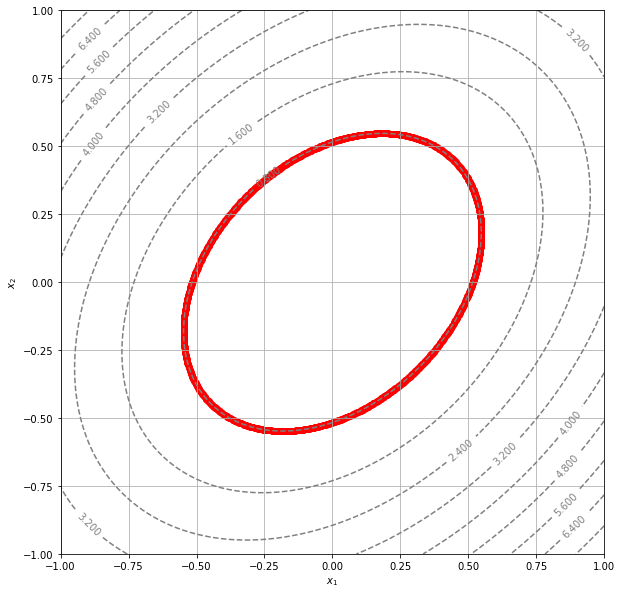

In [20]:
#Test de la fonction level_curve_ sur la courbe de niveau c=0.8 pour f1
def F(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.array([f1(x1,x2) - 0.8 , x1-x2])

point=Newton(F,0.8,0.8)
T=level_curve(f1,point[0],point[1])

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, # 20 levels, automatically selected
)
plt.scatter(T[0],T[1],c='r')


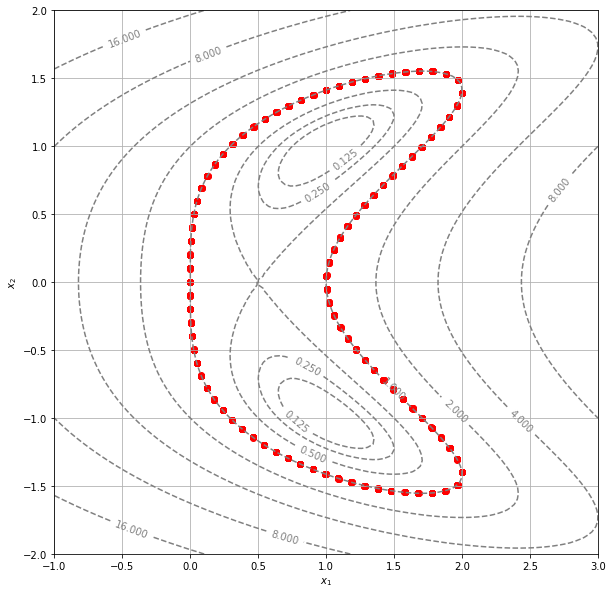

In [21]:
#Test de la fonction level_curve sur la courbe de niveau c=1 pour f2
def F(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.array([f2(x1,x2) - 1 , x1-x2])

point=Newton(F,0.8,0.8)
T=level_curve(f2,point[0],point[1])

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.scatter(T[0],T[1],c='r')

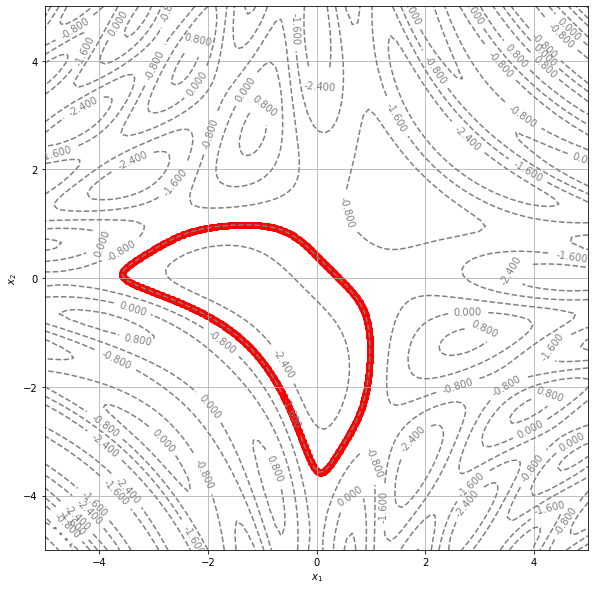

In [22]:
#Test de la fonction level_curve sur la courbe de niveau c=-1.6 pour f3
def F(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.array([f3(x1,x2) + 1.6 , x1-x2])

point=Newton(F,0.8,0.8)
T=level_curve(f3,point[0],point[1])

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
plt.scatter(T[0],T[1],c='r')

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

Dans la courbe de la fonction de Rosenbrock, les courbes de niveau s'auto-intersectent. Le gradient étant othogonal aux courbes de niveau, une telle situtation implique un gradient nul. Le point correspondant n'est cependant ni un maximum ni un miminum de la fonction. Physiquement cela correspondrait à un col, plateau au sein d'une chaîne de montagnes; avec cette analogie on peut sentir la rareté de la chose. 
En considérant que les courbes de niveau ne sont pas auto-intersectantes, on peut donc se contenter de regarder si le segment coupe le premier segment ou non.

In [23]:
#def intersect(p1a,p1b,p2a,p2b,precision=10e-4):
#    test=False
#    T=np.linspace(0,1,100)
#    s1=np.array( [(1-t)*p1a + t*p1b for t in T])
#    s2=np.array([(1-t)*p2a + t*p2b for t in T])
#    #plt.plot(s1[:,0],s1[:,1])
#    #plt.plot(s2[:,0],s2[:,1])
#    #plt.show()
#    
#    for i in s1:
#        for j in s2:
#            if (i[0]-j[0])**2 + (i[1]-j[1])**2 < precision:
#                return True
#    return test

def counter_clock_wise(P1,P2,P3):
    return (P3[1]-P1[1]) * (P2[0]-P1[0]) > (P2[1]-P1[1]) * (P3[0]-P1[0])

# Return true if line segments AB and CD intersect
def intersection_segment(P1,P2,P3,P4):
    return counter_clock_wise(P1,P3,P4) != counter_clock_wise(P2,P3,P4) and counter_clock_wise(P1,P2,P3) != counter_clock_wise(P1,P2,P4)

Par soucis d'optimisation, nous utiliserons la deuxième fonction intersection_segment qui réduit significativement le temps d'exécution. Un %timeit sur ces fonctions nous donne (sur mon ordinateur):  
intersection_segment : 100 µs ± 7.82 µs per loop  
intersect : 12.7 ms ± 3.22 ms per loop  

In [24]:
def level_curve2(f, x0, y0,N=1000, delta=0.1, eps=eps):
    Lx=[x0]
    Ly=[y0]
    gr=grad(f)
    x01,y01=vect_normal(gr(x0,y0),x0,y0,delta)
    ct=f(x0,y0)
    for i in range(N-1):
        def F(x,y):
            return np.array([f(x,y)-ct,((x-x0)**2+(y-y0)**2)**(1/2)-delta])
        x02,y02=Newton(F,x01,y01)
        x0,y0=x02,y02
        Lx.append(x0)
        Ly.append(y0)
        if intersection_segment((Lx[-2],Ly[-2]),(Lx[-1],Ly[-1]),(Lx[0],Ly[0]),(Lx[1],Ly[1])) and i > 2:
            Lx.pop()
            Ly.pop()
            return np.array([Lx,Ly])
        x01,y01=vect_normal(gr(x0,y0),x0,y0,delta)
    return np.array([Lx,Ly])
      

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

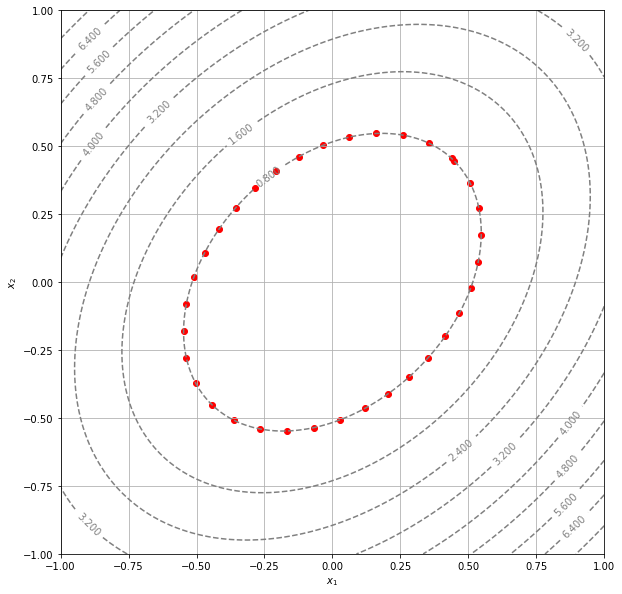

In [25]:
#Test de la fonction level_curve_oversampling sur la courbe de niveau c=0.8 pour f1 sans relier les points
def F(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.array([f1(x1,x2) - 0.8 , x1-x2])

point=Newton(F,0.8,0.8)
T=level_curve2(f1,point[0],point[1])

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, # 10 levels, automatically selected
)
plt.scatter(T[0],T[1],c='r')

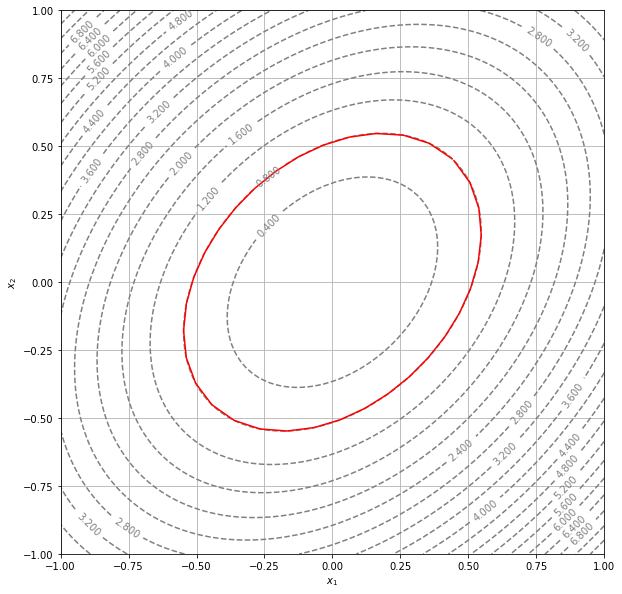

In [26]:
#Test de la fonction level_curve2 sur la courbe de niveau c=0.8 pour f1 en reliant les points
point=Newton(F,0.8,0.8)
T=level_curve2(f1,point[0],point[1])

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=20, # 20 levels, automatically selected
)
plt.plot(T[0],T[1],c='r')

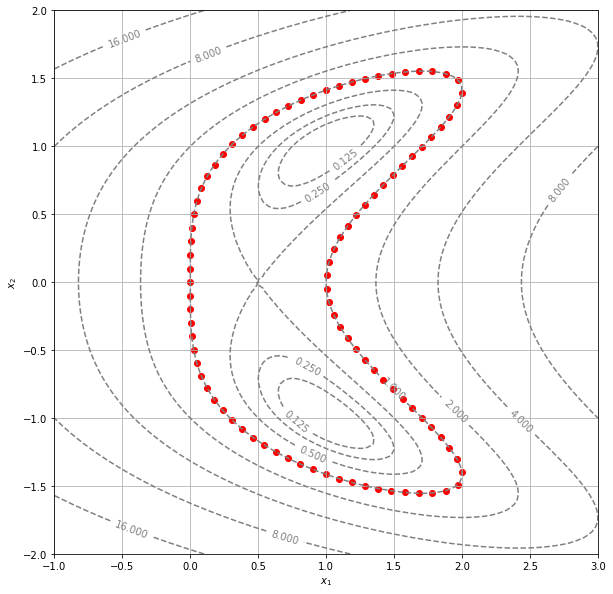

In [27]:
#Test de la fonction level_curve2 sur la courbe de niveau c=1 pour f2
def F(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.array([f2(x1,x2) - 1 , x1-x2])

point=Newton(F,0.8,0.8)
T=level_curve2(f2,point[0],point[1])

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.scatter(T[0],T[1],c='r')

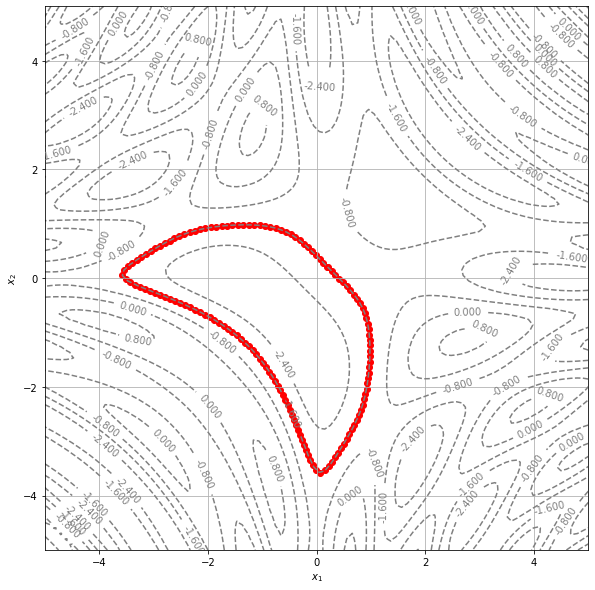

In [28]:
#Test de la fonction level_curve2 sur la courbe de niveau c=-1.6 pour f3
def F(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.array([f3(x1,x2) + 1.6 , x1-x2])

point=Newton(F,0.8,0.8)
T=level_curve2(f3,point[0],point[1])

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

plt.scatter(T[0],T[1],c='r')

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

##### question 8

En notant $P_1=(x_1,y_1)$ respectivement $P_2=(x_2,y_2)$ et $u_1=(a_1,b_1)$ (respectivement $u_2$).
Les conditions sur $\gamma$ et $\gamma'$ en $0$ et $1$ nous donnent:

$\gamma(0)=P_1$ donne : $x_1=x(0)=a$ et $y_1=y(0)=d$

$\gamma(1)=P_2$ donne : $x_2=x(1)=a+b+c$ et $y_2=y(1)=d+e+f$

$\gamma'(0)=\alpha\times{u_1}$ donne : $\alpha\times{a_1}=x'(0)=b$ et $\alpha\times{b_1}=x'(1)=b+2\times{c}$

$\gamma'(1)=\beta\times{u_2}$ donne : $\beta\times{a_2}=y'(0)=e$ et $\beta\times{b_2}=y'(1)=e+2\times{f}$

avec $\alpha$ et $\beta$ positifs strictement qui traduisent l'hypothèse même direction et même sens

Cela se résume dans le système suivant:
$\begin{cases}
x_1 &=a \\
y_1 &=d \\
x_2 &=a+b+c \\
y_2 &=d+e+f \\
\alpha\times{a_1} &=b \\
\alpha\times{b_1} &= e \\
\beta\times{a_2} &=b+2\times{c} \\
\beta\times{b_2} &=e+2\times{f} \\
\alpha &>0 \\
\beta &>0 \\
\end{cases}$

On a huit équations à 6 inconnues et deux conditions sur $\alpha$ et $\beta$, on résout le système...

$\begin{cases}
a &=x_1 \\
b &=\alpha\times{a_1} \\
c &=x_2-\alpha\times{a_1}-x_1 \\
d &=y_1 \\
e &=\alpha\times{b_1} \\
f &=y_2-\alpha\times{b_1}-y_1 \\
\beta\times{a_2} &= -\alpha\times{a_1}+2\times(x_2-x_1) \\
\beta\times{b_2} &=-\alpha\times{b_1}+2\times{(y_2-y_1)} \\
\alpha &>0 \\
\beta &>0 
\end{cases}$



Les conditions des lignes $7$ et $8$ donnent un système d'équations à deux inconnues $\alpha$ et $\beta$.
$\left\{\begin{matrix} \alpha a_1 + \beta a_2 = 2(x_{2}-x_{1}) \\ \alpha b_1 + \beta b_2 = 2(y_{2}-y_{1}) \end{matrix}\right.$

 Celui-ci admet une solution unique si et seulement si le déterminant de 
 $\begin{pmatrix} a_1 & a_2 \\ b_1 &b_2 \end{pmatrix}$ est non nul.

 Notons ce déterminant $d$

 $det=a_1{b_2} - a_2{b_1}$

 Les solutions valent alors:
 $\alpha = \frac{\begin{vmatrix} 2(x_2-x_1) & a_2 \\ 2(y_2-y_1)& b_2 \end{vmatrix}}{det}$
 
 et 
  $\beta = \frac{\begin{vmatrix} a_1 & 2(x_2-x_1) &\\ b_1 &2(y_2-y_1) \end{vmatrix}}{det}$


Il faut alors vérifier que $\alpha$ et $\beta$ ainsi obtenus sont positifs.

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [29]:
def gamma(t,P1,P2,u1,u2):
    x1=P1[0]
    y1=P1[1]
    x2=P2[0]
    y2=P2[1]
    a1=u1[0]
    b1=u1[1]
    a2=u2[0]
    b2=u2[1]
    det=a1*b2-a2*b1
    
    if det!=0:
        beta=2*(a1*(y2-y1)-b1*(x2-x1))/det
        alpha=2*(b2*(x2-x1)-a2*(y2-y1))/det
        if alpha>0 and beta>0:
            a=x1
            b=alpha*a1
            c=x2-x1-alpha*a1
            d=y1
            e=alpha*b1
            f=y2-y1-alpha*b1
            rep=np.array([a+t*b+(t**2)*c,d+t*e+(t**2)*f])
            return rep
    
    rep=np.array([x1+(x2-x1)*t,y1+(y2-y1)*t])
    return rep

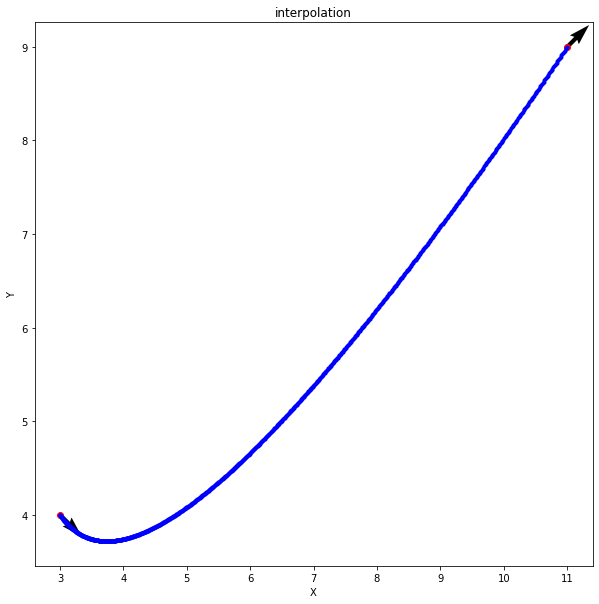

In [30]:
#exemple avec interpolation non linéaire

P1=[3,4]
P2=[11,9]
u1=[1,-1]
u2=[1,1]

T=np.linspace(0,1,1000)
Y=gamma(T,P1,P2,u1,u2)
#On plot les points 
plt.plot(P1[0],P1[1],color = 'red',marker='o')
plt.plot(P2[0],P2[1],color = 'red',marker='o')


plt.plot(Y[0],Y[1],marker='.',color='blue')

#On plot les vecteurs : 
plt.quiver(P1[0],P1[1],u1[0],u1[1])
plt.quiver(P2[0],P2[1],u2[0],u2[1])
plt.title("interpolation")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()

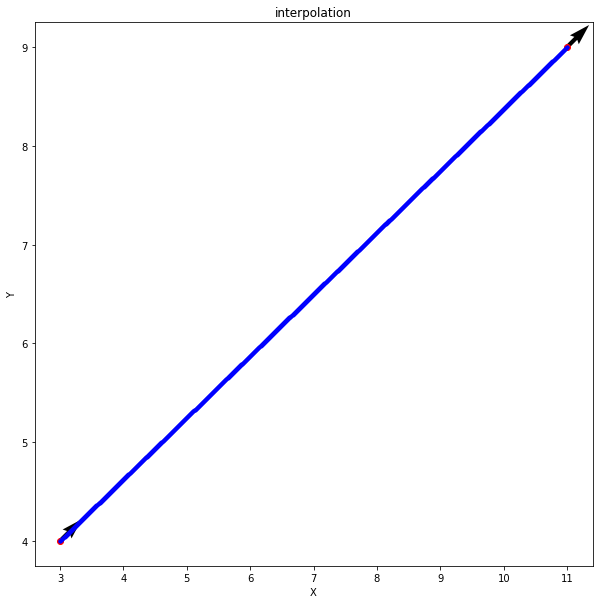

In [31]:
#exemple avec interpolation linéaire

P1=[3,4]
P2=[11,9]
u1=[1,1]
u2=[1,1]

T=np.linspace(0,1,1000)
Y=gamma(T,P1,P2,u1,u2)
#On plot les points 
plt.plot(P1[0],P1[1],color = 'red',marker='o')
plt.plot(P2[0],P2[1],color = 'red',marker='o')


plt.plot(Y[0],Y[1],marker='.',color='blue')

#On plot les vecteurs : 
plt.quiver(P1[0],P1[1],u1[0],u1[1])
plt.quiver(P2[0],P2[1],u2[0],u2[1])
plt.title("interpolation")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [32]:
def vect_normal2(vg):
    """retourne un vecteur normal à vg"""
    x,y=vg[0],vg[1]
    return np.array([y,-x])

def level_curve_oversampling(f, x0, y0,oversampling,N=1000, delta=0.1, eps=eps):
    Lx,Ly=level_curve2(f,x0,y0,N,delta,eps)
    if oversampling==1:
        return Lx,Ly
    else:
        NX=[]
        NY=[]
        LT=np.linspace(0,1,oversampling+1)#va prendre oversampling+1 points dont 0 et 1, ce qui rajoutera bien oversampling-1 points
        for k in range(len(Lx)-1):
                G=gamma(LT,np.array([Lx[k],Ly[k]]),np.array([Lx[k+1],Ly[k+1]]),vect_normal2(grad(f)(Lx[k],Ly[k])),vect_normal2(grad(f)(Lx[k+1],Ly[k+1])))
   
                u=G[0]
                v=G[1]
                for x in u:
                    NX.append(x)
                for y in v:
                    NY.append(y)
        G=gamma(LT,np.array([Lx[-1],Ly[-1]]),np.array([Lx[0],Ly[0]]),vect_normal2(grad(f)(Lx[-1],Ly[-1])),vect_normal2(grad(f)(Lx[0],Ly[0])))
        u=G[0]
        v=G[1]
        for x in u:
            NX.append(x)
        for y in v:
            NY.append(y)
                #cette méthode présente des doublons sur les points de Lx,Ly mais cela ne gênera pas les tracés
        return NX,NY
            
            
    
      

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

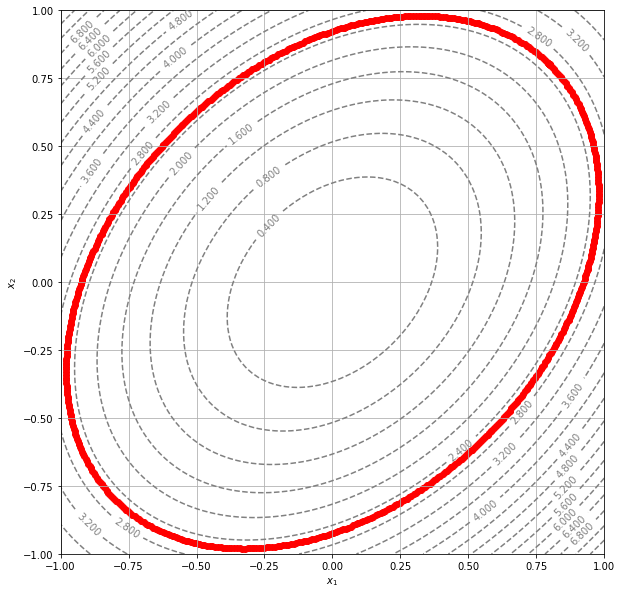

In [33]:
#test de la fonction level_curve_oversampling
T=level_curve_oversampling(f1,0.8,0.8,10)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=20, # 20 levels, automatically selected
)
plt.scatter(T[0],T[1],c='r')



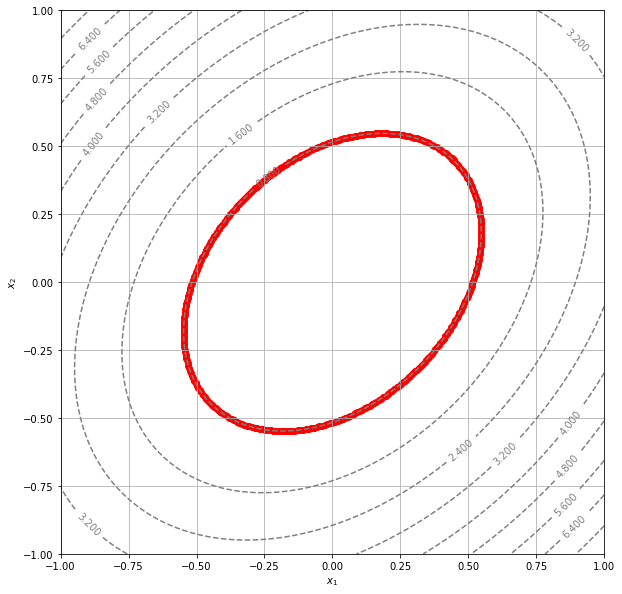

In [34]:
#Test de la fonction level_curve_oversampling sur la courbe de niveau c=0.8 pour f1 avec oversampling=10
def F(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.array([f1(x1,x2) - 0.8 , x1-x2])

point=Newton(F,0.8,0.8)
T=level_curve_oversampling(f1,point[0],point[1],10)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, # 10 levels, automatically selected
)
plt.scatter(T[0],T[1],c='r')

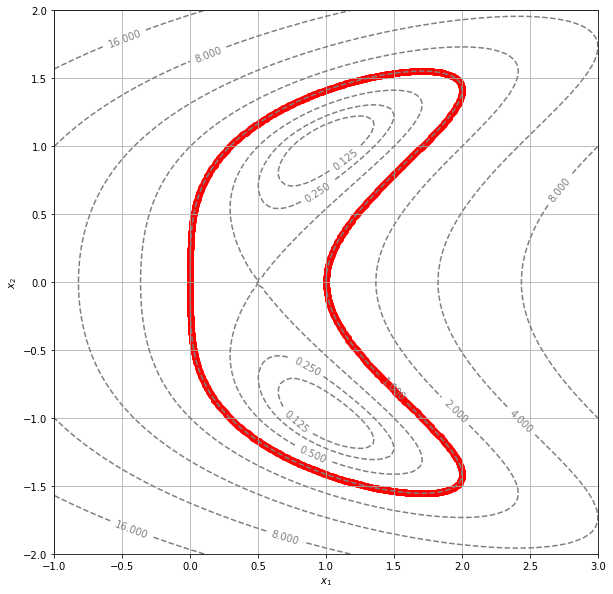

In [35]:
#Test de la fonction level_curve_oversampling sur la courbe de niveau c=1 pour f2 avec oversampling=10
def F(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.array([f2(x1,x2) - 1 , x1-x2])

point=Newton(F,0.8,0.8)
T=level_curve_oversampling(f2,point[0],point[1],10)

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.scatter(T[0],T[1],c='r')

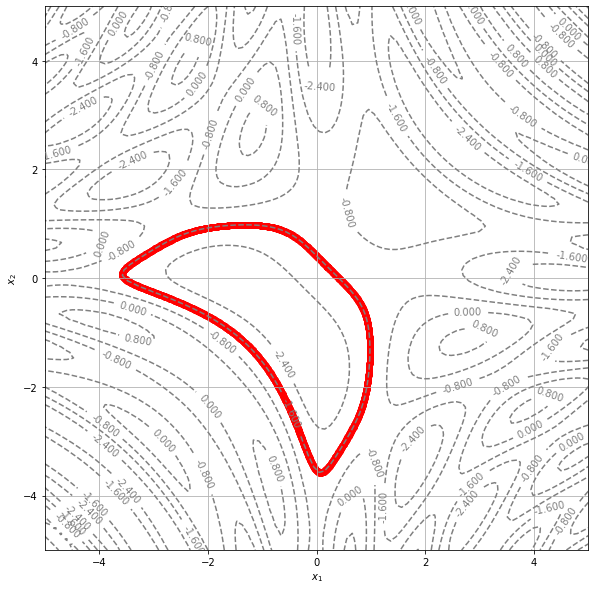

In [36]:
#Test de la fonction level_curve2 sur la courbe de niveau c=-1.6 pour f3 avec oversampling=10
def F(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.array([f3(x1,x2) + 1.6 , x1-x2])

point=Newton(F,0.8,0.8)
T=level_curve_oversampling(f3,point[0],point[1],10)

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

plt.scatter(T[0],T[1],c='r')